In [1]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [2]:
pd.set_option('max_columns', 200)

In [3]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

In [50]:
#PATHS for Features
ORIGINAL = '../input/m5-forecasting-accuracy/'
BASE = 'grid_df.pkl'
FEATURE1     = 'feature1.pkl'
FEATURE2     = 'feature2.pkl'

########################### Model params
#################################################################################
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'regression',#tweedie
#                     'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
#                     'verbose': -1,
                } 

########################### Vars
#################################################################################
VER = 1                          # Our model version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores

#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 1000                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon

#STORES ids
STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_validation.csv')['store_id']
STORES_IDS = list(STORES_IDS.unique())

remove_features = ['id','state_id','store_id','date','wm_yr_wk','d',TARGET]
rolling_mean_tmp_features = ['rolling_mean_tmp_1_7',
 'rolling_mean_tmp_1_14',
 'rolling_mean_tmp_1_30',
 'rolling_mean_tmp_1_60',
 'rolling_mean_tmp_7_7',
 'rolling_mean_tmp_7_14',
 'rolling_mean_tmp_7_30',
 'rolling_mean_tmp_7_60',
 'rolling_mean_tmp_14_7',
 'rolling_mean_tmp_14_14',
 'rolling_mean_tmp_14_30',
 'rolling_mean_tmp_14_60']
remove_features += rolling_mean_tmp_features

In [51]:
########################### Helper to load data by store ID
#################################################################################
# Read data
def get_data_by_store(store):
    
    df = pd.read_pickle(BASE)
    df = df[df['store_id']==store]
    for p in [FEATURE1, FEATURE2]:
        df_feat = pd.read_pickle(p)
        df = pd.merge(df, df_feat.drop(columns=['sales']), on=['id', 'd'], how='left')
        
    # Create features list
    features = [col for col in list(df) if col not in remove_features]
#     df = df[['id','d',TARGET]+features]
    
    train_mask = (df['d']>START_TRAIN)&(df['d']<=END_TRAIN-P_HORIZON)
    valid_mask = (df['d']>(END_TRAIN-P_HORIZON))&(df['d']<=END_TRAIN)
    test_mask = df['d']>END_TRAIN
        
    tran_df = df[train_mask].reset_index(drop=True)
    valid_df = df[valid_mask].reset_index(drop=True)
    test_df = df[test_mask].reset_index(drop=True)
    
    return tran_df, valid_df, test_df, features

In [52]:
predictions = pd.DataFrame()

########################### Train Models
#################################################################################
for store_id in STORES_IDS:
    
    start_time = time.time()
    
    # Get grid for current store
    tran_df, valid_df, test_df, features_columns = get_data_by_store(store_id)
    
    print('Train', store_id, tran_df.shape[0], valid_df.shape[0], test_df.shape[0])
    train_data = lgb.Dataset(tran_df[features_columns], label=tran_df[TARGET])
    valid_data = lgb.Dataset(valid_df[features_columns], label=valid_df[TARGET])
    
    # Launch seeder again to make lgb training 100% deterministic
    # with each "code line" np.random "evolves" 
    # so we need (may want) to "reset" it
    seed_everything(SEED)
    estimator = lgb.train(lgb_params,train_data,valid_sets = [valid_data],verbose_eval = 100)
    
    test_df[TARGET] = estimator.predict(test_df[features_columns])
    predictions = pd.concat([predictions, test_df], axis=0)
    
    print('%0.2f min: train' % ((time.time() - start_time) / 60))
    



Train CA_1 2593043 85372 85372
[100]	valid_0's rmse: 2.20795
[200]	valid_0's rmse: 2.17958
[300]	valid_0's rmse: 2.17269
[400]	valid_0's rmse: 2.16735
[500]	valid_0's rmse: 2.16388
[600]	valid_0's rmse: 2.16379
[700]	valid_0's rmse: 2.16265
[800]	valid_0's rmse: 2.16183
[900]	valid_0's rmse: 2.1606
[1000]	valid_0's rmse: 2.15875
[1100]	valid_0's rmse: 2.1595
[1200]	valid_0's rmse: 2.15894
[1300]	valid_0's rmse: 2.15883
[1400]	valid_0's rmse: 2.15928
7.15 min: train
Train CA_2 2427177 85372 85372
[100]	valid_0's rmse: 2.16997
[200]	valid_0's rmse: 2.12611
[300]	valid_0's rmse: 2.1155
[400]	valid_0's rmse: 2.1098
[500]	valid_0's rmse: 2.10694
[600]	valid_0's rmse: 2.10335
[700]	valid_0's rmse: 2.10098
[800]	valid_0's rmse: 2.09895
[900]	valid_0's rmse: 2.0981
[1000]	valid_0's rmse: 2.09744
[1100]	valid_0's rmse: 2.09562
[1200]	valid_0's rmse: 2.09401
[1300]	valid_0's rmse: 2.09351
[1400]	valid_0's rmse: 2.09162
6.86 min: train
Train CA_3 2588494 85372 85372
[100]	valid_0's rmse: 3.00278


KeyboardInterrupt: 

In [48]:
submission = pd.read_csv(ORIGINAL+'sample_submission.csv')
predictions_ = predictions[['id', 'date', 'sales']]
predictions_ = pd.pivot(predictions_, index = 'id', columns = 'date', values = 'sales').reset_index()
predictions_.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]
validation = submission[['id']].merge(predictions_, on = 'id')
final = pd.concat([validation, evaluation])

In [49]:
final

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.723611,0.650109,0.655657,0.668738,0.775059,1.013153,0.992110,0.645462,0.705936,0.686933,0.626610,0.795147,1.055680,0.882034,0.743943,0.680299,0.622962,0.640301,0.768124,1.058945,0.944420,0.749893,0.706895,0.666060,0.734059,0.833432,1.069518,1.033217
1,HOBBIES_1_002_CA_1_validation,0.301420,0.283539,0.284056,0.296537,0.361753,0.420432,0.430167,0.274946,0.280370,0.254698,0.239542,0.301383,0.342650,0.298053,0.212301,0.199730,0.180935,0.189565,0.237228,0.284277,0.281272,0.198015,0.189577,0.270924,0.277650,0.340734,0.378465,0.364909
2,HOBBIES_1_003_CA_1_validation,0.382170,0.335195,0.342870,0.346132,0.412114,0.610862,0.504317,0.366598,0.333204,0.322328,0.305800,0.404019,0.614285,0.405783,0.315492,0.296489,0.312006,0.322091,0.424217,0.572771,0.599557,0.439604,0.423643,0.425267,0.407423,0.548481,0.671105,0.627480
3,HOBBIES_1_004_CA_1_validation,2.086001,1.649858,1.555910,1.703514,2.293958,3.392283,3.884206,1.998852,1.658347,1.665621,1.473658,1.953799,3.313692,2.970853,1.968884,1.497516,1.528354,1.467343,1.950363,2.711923,3.427125,2.121972,1.551881,1.493200,1.580777,2.123560,3.555176,3.659971
4,HOBBIES_1_005_CA_1_validation,1.118726,0.943852,1.007778,0.991754,1.150185,1.570529,1.786516,1.096216,1.050756,0.992659,0.880700,1.109667,1.420259,1.192833,1.021905,1.012052,0.932312,0.921061,0.983432,1.447408,1.456484,1.035851,0.926199,0.966798,0.887626,1.121249,1.400172,1.504004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60976,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60978,FOODS_3_826_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
########################### Permutation importance Test
########################### https://www.kaggle.com/dansbecker/permutation-importance @dansbecker
#################################################################################

# Let's creat validation dataset and features
features_columns = [col for col in list(grid_df) if col not in remove_features]
validation_df = grid_df[grid_df['d']>(END_TRAIN-28)].reset_index(drop=True)

def permutation_importance(model, validation_df, features_columns, target, metric=rmse, verbose=0)

    list_ = []
    # Make normal prediction with our model and save score
    validation_df['preds'] = model.predict(validation_df[features_columns])
    base_score = metric(validation_df[target], validation_df['preds'])
    if verbose>0:
        print('Standart RMSE', base_score)

    # Now we are looping over all our numerical features
    for col in features_columns:

        # We will make validation set copy to restore
        # features states on each run
        temp_df = validation_df.copy()

        # Error here appears if we have "categorical" features and can't 
        # do np.random.permutation without disrupt categories
        # so we need to check if feature is numerical
        if temp_df[col].dtypes.name != 'category':
            temp_df[col] = np.random.permutation(temp_df[col].values)
            temp_df['preds'] = model.predict(temp_df[features_columns])
            cur_score = metric(temp_df[target], temp_df['preds'])
            
            list_.append({'feature':col, 'permutation_importance':np.round(cur_score - base_score, 4)})
            # If our current rmse score is less than base score
            # it means that feature most probably is a bad one
            # and our model is learning on noise
            if verbose>0:
                print(col, np.round(cur_score - base_score, 4))
            
    return pd.DataFrame(list_).sort_values(by=['permutation_importance'], ascending=False)


permutation_importance_df = permutation_importance(estimator, valid_df, features_columns, TARGET, metric=rmse, verbose=1)

In [ ]:
def process(model_, param_, feature_, target_):
    
    

predictions = pd.DataFrame()

########################### Train Models
#################################################################################
for store_id in STORES_IDS:
    
    start_time = time.time()
    
    # Get grid for current store
    tran_df, valid_df, test_df, features_columns = get_data_by_store(store_id)
    
    print('Train', store_id, tran_df.shape[0], valid_df.shape[0], test_df.shape[0])
    train_data = lgb.Dataset(tran_df[features_columns], label=tran_df[TARGET])
    valid_data = lgb.Dataset(valid_df[features_columns], label=valid_df[TARGET])
    
    # Launch seeder again to make lgb training 100% deterministic
    # with each "code line" np.random "evolves" 
    # so we need (may want) to "reset" it
    seed_everything(SEED)
    estimator = lgb.train(lgb_params,train_data,valid_sets = [valid_data],verbose_eval = 100)
    
    test_df[TARGET] = estimator.predict(test_df[features_columns])
    predictions = pd.concat([predictions, test_df], axis=0)
    
    print('%0.2f min: train' % ((time.time() - start_time) / 60))
    
submission = pd.read_csv(ORIGINAL+'sample_submission.csv')
predictions = predictions[['id', 'date', 'sales']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'sales').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]
validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])


In [ ]:
for model_, param_, feature_, target_ in zip(MODELS, PARAMS, FEATURES, TARGETS):
    predictions_test = pd.DataFrame()
    predictions_valid = pd.DataFrame()
    
# add new features for validation and test

extra_features_df = pd.DataFrame()

for m, p, f in zip(MODELS, PARAMS, FEATURES):
    predictions_test = pd.DataFrame()
    
blend

In [52]:
predictions = pd.DataFrame()

########################### Train Models
#################################################################################
for store_id in STORES_IDS:
    
    start_time = time.time()
    
    # Get grid for current store
    tran_df, valid_df, test_df, features_columns = get_data_by_store(store_id)
    
    print('Train', store_id, tran_df.shape[0], valid_df.shape[0], test_df.shape[0])
    train_data = lgb.Dataset(tran_df[features_columns], label=tran_df[TARGET])
    valid_data = lgb.Dataset(valid_df[features_columns], label=valid_df[TARGET])
    
    # Launch seeder again to make lgb training 100% deterministic
    # with each "code line" np.random "evolves" 
    # so we need (may want) to "reset" it
    seed_everything(SEED)
    estimator = lgb.train(lgb_params,train_data,valid_sets = [valid_data],verbose_eval = 100)
    
    test_df[TARGET] = estimator.predict(test_df[features_columns])
    predictions = pd.concat([predictions, test_df], axis=0)
    
    print('%0.2f min: train' % ((time.time() - start_time) / 60))
    
submission = pd.read_csv(ORIGINAL+'sample_submission.csv')
predictions = predictions[['id', 'date', 'sales']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'sales').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]
validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
predictions

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.753364,0.372763,0.353091,0.381572,0.536785,0.651927,0.680637,0.397326,0.384777,0.374135,0.379084,0.461532,0.482075,0.490870,0.320430,0.341305,0.330792,0.337579,0.473426,0.436736,0.432840,0.306836,0.279909,0.306817,0.298687,0.426929,0.420848,0.359973
1,FOODS_1_001_CA_2_validation,0.974716,0.565126,0.601542,0.570594,0.630309,0.793670,0.848740,0.488541,0.480527,0.545053,0.538270,0.601419,0.685247,0.738316,0.603838,0.591522,0.573321,0.594381,0.669131,0.614177,0.902013,0.565714,0.644389,0.596173,0.617766,0.600229,0.691482,0.710191
2,FOODS_1_001_CA_3_validation,0.829917,0.735327,0.732702,0.758117,0.837166,1.258349,1.454660,0.970444,0.940762,0.990260,1.045927,1.137236,1.201074,1.369044,0.950002,0.915721,0.994786,0.952586,1.049565,1.167894,1.297689,0.828820,0.732977,0.872496,0.851310,0.962719,1.055566,1.321935
3,FOODS_1_001_CA_4_validation,0.387975,0.350939,0.333824,0.356137,0.344386,0.391143,0.420865,0.322271,0.288244,0.278890,0.295107,0.283069,0.309663,0.318415,0.278830,0.277125,0.285395,0.308358,0.289402,0.311588,0.286851,0.284288,0.278223,0.287540,0.291315,0.291584,0.262166,0.259393
4,FOODS_1_001_TX_1_validation,0.072094,0.507415,0.524390,0.504026,0.568891,0.649838,0.689267,0.399104,0.470053,0.471322,0.485243,0.522667,0.604556,0.543830,0.424878,0.422160,0.459691,0.477188,0.506873,0.531166,0.486433,0.385497,0.350556,0.391282,0.402661,0.435097,0.448363,0.467152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.344112,0.261745,0.302792,0.330150,0.402568,0.444509,0.419241,0.208050,0.211886,0.197649,0.218592,0.273312,0.300768,0.259636,0.170862,0.157752,0.195934,0.197987,0.232935,0.236546,0.227833,0.157229,0.156273,0.170139,0.177771,0.218580,0.233093,0.232806
30486,HOUSEHOLD_2_516_TX_3_validation,0.134777,0.170999,0.178864,0.199631,0.225994,0.280616,0.288602,0.179551,0.200696,0.204469,0.191483,0.202253,0.410368,0.403696,0.415672,0.460243,0.462185,0.447597,0.456815,0.306723,0.292409,0.281561,0.299351,0.321353,0.336805,0.367862,0.216590,0.199232
30487,HOUSEHOLD_2_516_WI_1_validation,0.083522,0.207828,0.201291,0.198868,0.231284,0.324771,0.264118,0.160338,0.151203,0.171975,0.169479,0.220084,0.314483,0.242377,0.154740,0.153696,0.165006,0.169707,0.202490,0.281163,0.241349,0.175387,0.165365,0.174130,0.187016,0.214398,0.300609,0.274307
30488,HOUSEHOLD_2_516_WI_2_validation,0.045178,0.160927,0.158716,0.175260,0.180075,0.244127,0.202608,0.193090,0.182179,0.151535,0.148810,0.177062,0.181750,0.153212,0.122130,0.119656,0.125053,0.127011,0.138933,0.142691,0.119919,0.112715,0.112751,0.115004,0.115141,0.122027,0.125015,0.116689


In [49]:
final.to_csv('submission_v'+str(VER)+'.csv', index=False)

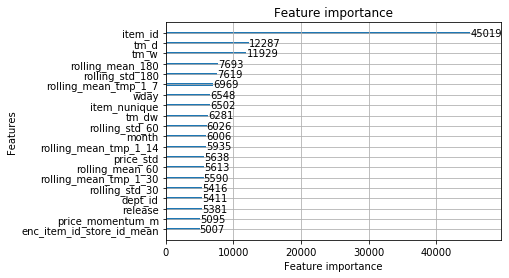

In [47]:
lgb.plot_importance(estimator, max_num_features=20)

In [48]:
final

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.821748,0.546170,0.577027,0.560216,0.710541,0.802194,0.716507,0.413299,0.391911,0.369882,0.311473,0.395097,0.428945,0.532432,0.341799,0.390623,0.383022,0.318263,0.356393,0.464782,0.391498,0.321274,0.341303,0.297775,0.335558,0.403198,0.378247,0.404045
1,HOBBIES_1_002_CA_1_validation,0.209110,0.274605,0.291788,0.310513,0.391540,0.471698,0.429478,0.339461,0.329629,0.334173,0.325755,0.389337,0.442048,0.391994,0.234328,0.228111,0.218437,0.231130,0.278460,0.369053,0.340073,0.235372,0.224406,0.238184,0.261400,0.320103,0.401475,0.353664
2,HOBBIES_1_003_CA_1_validation,0.418001,0.356824,0.394618,0.382554,0.480338,0.652530,0.525161,0.364880,0.325913,0.319575,0.326835,0.424177,0.488786,0.451398,0.266440,0.274797,0.253831,0.272761,0.341299,0.394016,0.369108,0.236840,0.245148,0.241926,0.247114,0.333431,0.386195,0.363742
3,HOBBIES_1_004_CA_1_validation,2.016384,0.836739,0.894578,1.047542,1.199820,1.339806,1.444122,0.794607,0.744242,0.764918,0.703539,0.969340,1.187285,1.304856,0.873512,0.947123,1.120195,1.097042,1.301493,1.305626,1.504460,0.908478,0.908350,0.853804,1.008722,1.299201,1.225603,1.254227
4,HOBBIES_1_005_CA_1_validation,0.961967,0.560715,0.629874,0.570380,0.632952,0.907418,0.997245,0.514228,0.523284,0.509987,0.523447,0.668283,0.766900,0.688109,0.519631,0.517409,0.496692,0.563333,0.629883,0.709794,0.655356,0.500859,0.473934,0.492890,0.464575,0.671984,0.626136,0.577867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60976,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60978,FOODS_3_826_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
